In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve,plot_precision_recall_curve,average_precision_score,recall_score,classification_report,precision_score

In [2]:
df1=pd.read_csv(r'C:\Users\Viddy\Downloads\archive\fraudTest.csv')
df1["trans_date_trans_time"] = pd.to_datetime(df1['trans_date_trans_time'])
df1['day_of_week'] = df1['trans_date_trans_time'].dt.day_name()

df1['dob']=df1['dob'].astype('datetime64[ns]')
df1['age']=(datetime.today()-df1['dob'])//np.timedelta64(1, 'Y')


columns_interest=['category','amt', 'gender','lat','long','city_pop',
                   'age', 'is_fraud', 'day_of_week','merch_long','merch_lat']
df_interest=df1[columns_interest]

In [3]:
df2=df_interest.copy()
df2.head()

,category,amt,gender,lat,long,city_pop,age,is_fraud,day_of_week,merch_long,merch_lat
0,personal_care,2.86,M,33.9659,-80.9355,333497,53,0,Sunday,-81.200714,33.986391
1,personal_care,29.84,F,40.3207,-110.4360,302,31,0,Sunday,-109.960431,39.450498
2,health_fitness,41.28,F,40.6729,-73.5365,34496,50,0,Sunday,-74.196111,40.495810
3,misc_pos,60.05,M,28.5697,-80.8191,54767,34,0,Sunday,-80.883061,28.812398
4,travel,3.19,M,44.2529,-85.0170,1126,66,0,Sunday,-85.884734,44.959148


In [4]:
df2[['gender','category','day_of_week']]=df2[['gender','category','day_of_week']].apply(lambda x: x.astype('category',copy=True))

df2.dtypes

category       category
amt             float64
gender         category
lat             float64
long            float64
city_pop          int64
age               int64
is_fraud          int64
day_of_week    category
merch_long      float64
merch_lat       float64
dtype: object

In [5]:
for col in df2.select_dtypes(include='category'):
    print(col,'=',df2[col].nunique())
   

category = 14
gender = 2
day_of_week = 7


# Just to explain why excluded jobs and merchant

In [31]:
df1['job'].nunique()


478

## Changing gender to binary

In [7]:
dummy= pd.get_dummies(df2['gender'])
df3=pd.concat([df2,dummy],axis=1)
df3.drop(['gender','F'],axis=1,inplace=True)
df3

,category,amt,lat,long,city_pop,age,is_fraud,day_of_week,merch_long,merch_lat,M
0,personal_care,2.86,33.9659,-80.9355,333497,53,0,Sunday,-81.200714,33.986391,1
1,personal_care,29.84,40.3207,-110.4360,302,31,0,Sunday,-109.960431,39.450498,0
2,health_fitness,41.28,40.6729,-73.5365,34496,50,0,Sunday,-74.196111,40.495810,0
3,misc_pos,60.05,28.5697,-80.8191,54767,34,0,Sunday,-80.883061,28.812398,1
4,travel,3.19,44.2529,-85.0170,1126,66,0,Sunday,-85.884734,44.959148,1
...,...,...,...,...,...,...,...,...,...,...,...
555714,health_fitness,43.77,40.4931,-91.8912,519,55,0,Thursday,-91.333331,39.946837,1
555715,kids_pets,111.84,29.0393,-95.4401,28739,21,0,Thursday,-96.186633,29.661049,1
555716,kids_pets,86.88,46.1966,-118.9017,3684,39,0,Thursday,-119.715054,46.658340,0
555717,travel,7.99,44.6255,-116.4493,129,55,0,Thursday,-117.080888,44.470525,1


# Changing Category via one hot encoding

In [8]:
dummy1= pd.get_dummies(df3['category'])
df4=pd.concat([df3,dummy1],axis=1)
df4.drop(['category'],axis=1,inplace=True)
df4

,amt,lat,long,city_pop,age,is_fraud,day_of_week,merch_long,merch_lat,M,...,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
0,2.86,33.9659,-80.9355,333497,53,0,Sunday,-81.200714,33.986391,1,...,0,0,0,0,0,0,1,0,0,0
1,29.84,40.3207,-110.4360,302,31,0,Sunday,-109.960431,39.450498,0,...,0,0,0,0,0,0,1,0,0,0
2,41.28,40.6729,-73.5365,34496,50,0,Sunday,-74.196111,40.495810,0,...,0,1,0,0,0,0,0,0,0,0
3,60.05,28.5697,-80.8191,54767,34,0,Sunday,-80.883061,28.812398,1,...,0,0,0,0,0,1,0,0,0,0
4,3.19,44.2529,-85.0170,1126,66,0,Sunday,-85.884734,44.959148,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,43.77,40.4931,-91.8912,519,55,0,Thursday,-91.333331,39.946837,1,...,0,1,0,0,0,0,0,0,0,0
555715,111.84,29.0393,-95.4401,28739,21,0,Thursday,-96.186633,29.661049,1,...,0,0,0,1,0,0,0,0,0,0
555716,86.88,46.1966,-118.9017,3684,39,0,Thursday,-119.715054,46.658340,0,...,0,0,0,1,0,0,0,0,0,0
555717,7.99,44.6255,-116.4493,129,55,0,Thursday,-117.080888,44.470525,1,...,0,0,0,0,0,0,0,0,0,1


# Changing day_of_week 

In [9]:
dummy2= pd.get_dummies(df4['day_of_week'])
df5=pd.concat([df4,dummy2],axis=1)
df5.drop(['day_of_week'],axis=1,inplace=True)
df5

,amt,lat,long,city_pop,age,is_fraud,merch_long,merch_lat,M,entertainment,...,shopping_net,shopping_pos,travel,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2.86,33.9659,-80.9355,333497,53,0,-81.200714,33.986391,1,0,...,0,0,0,0,0,0,1,0,0,0
1,29.84,40.3207,-110.4360,302,31,0,-109.960431,39.450498,0,0,...,0,0,0,0,0,0,1,0,0,0
2,41.28,40.6729,-73.5365,34496,50,0,-74.196111,40.495810,0,0,...,0,0,0,0,0,0,1,0,0,0
3,60.05,28.5697,-80.8191,54767,34,0,-80.883061,28.812398,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3.19,44.2529,-85.0170,1126,66,0,-85.884734,44.959148,1,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,43.77,40.4931,-91.8912,519,55,0,-91.333331,39.946837,1,0,...,0,0,0,0,0,0,0,1,0,0
555715,111.84,29.0393,-95.4401,28739,21,0,-96.186633,29.661049,1,0,...,0,0,0,0,0,0,0,1,0,0
555716,86.88,46.1966,-118.9017,3684,39,0,-119.715054,46.658340,0,0,...,0,0,0,0,0,0,0,1,0,0
555717,7.99,44.6255,-116.4493,129,55,0,-117.080888,44.470525,1,0,...,0,0,1,0,0,0,0,1,0,0


In [10]:
df5.head()

,amt,lat,long,city_pop,age,is_fraud,merch_long,merch_lat,M,entertainment,...,shopping_net,shopping_pos,travel,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2.86,33.9659,-80.9355,333497,53,0,-81.200714,33.986391,1,0,...,0,0,0,0,0,0,1,0,0,0
1,29.84,40.3207,-110.4360,302,31,0,-109.960431,39.450498,0,0,...,0,0,0,0,0,0,1,0,0,0
2,41.28,40.6729,-73.5365,34496,50,0,-74.196111,40.495810,0,0,...,0,0,0,0,0,0,1,0,0,0
3,60.05,28.5697,-80.8191,54767,34,0,-80.883061,28.812398,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3.19,44.2529,-85.0170,1126,66,0,-85.884734,44.959148,1,0,...,0,0,1,0,0,0,1,0,0,0


In [11]:
df5.describe()

,amt,lat,long,city_pop,age,is_fraud,merch_long,merch_lat,M,entertainment,...,shopping_net,shopping_pos,travel,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,555719.000000,555719.000000,555719.000000,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,...,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000
mean,69.392810,38.543253,-90.231325,8.822189e+04,47.221220,0.003860,-90.231380,38.542798,0.451367,0.072166,...,0.075180,0.089597,0.031399,0.113018,0.207184,0.112053,0.167527,0.106989,0.198145,0.095084
std,156.745941,5.061336,13.721780,3.003909e+05,17.426961,0.062008,13.733071,5.095829,0.497630,0.258763,...,0.263682,0.285604,0.174394,0.316615,0.405289,0.315432,0.373446,0.309100,0.398602,0.293331
min,1.000000,20.027100,-165.672300,2.300000e+01,16.000000,0.000000,-166.671575,19.027422,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.630000,34.668900,-96.798000,7.410000e+02,34.000000,0.000000,-96.905129,34.755302,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47.290000,39.371600,-87.476900,2.408000e+03,45.000000,0.000000,-87.445204,39.376593,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,83.010000,41.894800,-80.175200,1.968500e+04,58.000000,0.000000,-80.264637,41.954163,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,22768.110000,65.689900,-67.950300,2.906700e+06,96.000000,1.000000,-66.952026,66.679297,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Scaling


In [12]:
scaler = StandardScaler()
standard_df = scaler.fit_transform(df5[['age','lat','long','merch_long','merch_lat','amt','city_pop']])
standard_df = pd.DataFrame(standard_df,columns=['age_scaled','lat_scaled','long_scaled','merch_long_scaled','merch_lat_scaled','amt_scaled','city_pop_scaled'])

In [13]:
standard_df.describe()

,age_scaled,lat_scaled,long_scaled,merch_long_scaled,merch_lat_scaled,amt_scaled,city_pop_scaled
count,5.557190e+05,5.557190e+05,5.557190e+05,5.557190e+05,5.557190e+05,5.557190e+05,5.557190e+05
mean,7.678525e-16,-1.237700e-15,8.612611e-16,7.106133e-16,-3.102176e-15,-3.303635e-17,-1.492910e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.791549e+00,-3.658356e+00,-5.497905e+00,-5.566145e+00,-3.829680e+00,-4.363295e-01,-2.936140e-01
25%,-7.586653e-01,-7.654809e-01,-4.785590e-01,-4.859623e-01,-7.432548e-01,-3.812722e-01,-2.912238e-01
50%,-1.274589e-01,1.636619e-01,2.007340e-01,2.028810e-01,1.636232e-01,-1.410105e-01,-2.856743e-01
75%,6.185123e-01,6.621868e-01,7.328593e-01,7.257483e-01,6.694432e-01,8.687435e-02,-2.281592e-01
max,2.799044e+00,5.363538e+00,1.623772e+00,1.695133e+00,5.521481e+00,1.448123e+02,9.382710e+00


In [14]:
df6=pd.concat([df5,standard_df],axis=1)
df6.head()

,amt,lat,long,city_pop,age,is_fraud,merch_long,merch_lat,M,entertainment,...,Thursday,Tuesday,Wednesday,age_scaled,lat_scaled,long_scaled,merch_long_scaled,merch_lat_scaled,amt_scaled,city_pop_scaled
0,2.86,33.9659,-80.9355,333497,53,0,-81.200714,33.986391,1,0,...,0,0,0,0.331600,-0.904377,0.677451,0.657586,-0.894145,-0.424463,0.816521
1,29.84,40.3207,-110.4360,302,31,0,-109.960431,39.450498,0,0,...,0,0,0,-0.930813,0.351182,-1.472454,-1.436610,0.178126,-0.252337,-0.292685
2,41.28,40.6729,-73.5365,34496,50,0,-74.196111,40.495810,0,0,...,0,0,0,0.159453,0.420768,1.216667,1.167640,0.383257,-0.179353,-0.178853
3,60.05,28.5697,-80.8191,54767,34,0,-80.883061,28.812398,1,0,...,0,0,0,-0.758665,-1.970539,0.685934,0.680717,-1.909485,-0.059605,-0.111371
4,3.19,44.2529,-85.0170,1126,66,0,-85.884734,44.959148,1,0,...,0,0,0,1.077572,1.128092,0.380004,0.316510,1.259139,-0.422358,-0.289942


In [15]:

df7=df6.drop(['age','lat','long','merch_long','merch_lat','amt','city_pop'],axis=1).copy()
df7.head()

,is_fraud,M,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,...,Thursday,Tuesday,Wednesday,age_scaled,lat_scaled,long_scaled,merch_long_scaled,merch_lat_scaled,amt_scaled,city_pop_scaled
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0.331600,-0.904377,0.677451,0.657586,-0.894145,-0.424463,0.816521
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.930813,0.351182,-1.472454,-1.436610,0.178126,-0.252337,-0.292685
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0.159453,0.420768,1.216667,1.167640,0.383257,-0.179353,-0.178853
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,-0.758665,-1.970539,0.685934,0.680717,-1.909485,-0.059605,-0.111371
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1.077572,1.128092,0.380004,0.316510,1.259139,-0.422358,-0.289942


In [16]:
x=df7.drop(['is_fraud'],axis=1)
y=df7['is_fraud']


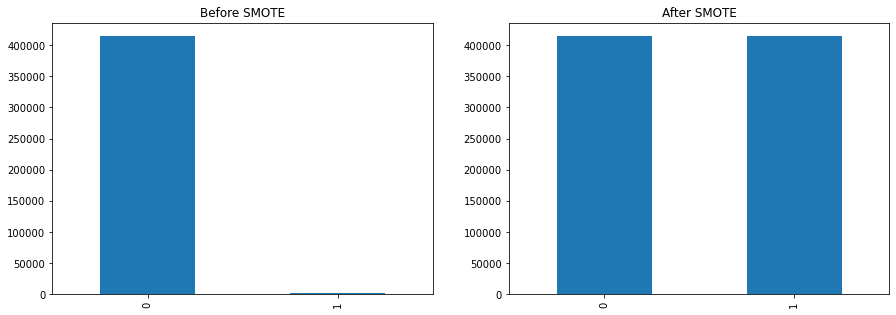

In [17]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=125)

sm = SMOTE()
X_train_new, y_train_new = sm.fit_resample(X_train, y_train)


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before SMOTE')
pd.Series(y_train).value_counts().plot.bar(ax=ax1)

ax2.set_title('After SMOTE')  
pd.Series(y_train_new).value_counts().plot.bar(ax=ax2)

plt.show()

In [18]:
X_train, y_train = sm.fit_resample(X_train, y_train)

# Applying decision tree

In [19]:
dtree = DecisionTreeClassifier(random_state=125)
dtree.fit(X_train,y_train)
dtree_pred = dtree.predict(X_test)
print(confusion_matrix(y_test,dtree_pred))
print('\n')
print(classification_report(y_test,dtree_pred))

[[137888    466]
 [   201    375]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    138354
           1       0.45      0.65      0.53       576

    accuracy                           1.00    138930
   macro avg       0.72      0.82      0.76    138930
weighted avg       1.00      1.00      1.00    138930



# Random Forest

In [20]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)

print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred))

[[138208    146]
 [   169    407]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    138354
           1       0.74      0.71      0.72       576

    accuracy                           1.00    138930
   macro avg       0.87      0.85      0.86    138930
weighted avg       1.00      1.00      1.00    138930



# Logistic Regression

In [21]:
lg=LogisticRegression()
lg.fit(X_train,y_train)
lg_pred = lg.predict(X_test)

print(confusion_matrix(y_test,lg_pred))
print('\n')
print(classification_report(y_test,lg_pred))

C:\Users\Viddy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[134606   3748]
 [   165    411]]


              precision    recall  f1-score   support

           0       1.00      0.97      0.99    138354
           1       0.10      0.71      0.17       576

    accuracy                           0.97    138930
   macro avg       0.55      0.84      0.58    138930
weighted avg       1.00      0.97      0.98    138930



In [55]:
gb=GradientBoostingClassifier()
gb.fit(X_train,y_train)
gb_pred = gb.predict(X_test)

print(confusion_matrix(y_test,gb_pred))
print('\n')
print(classification_report(y_test,gb_pred))

[[133719   4635]
 [    51    525]]


              precision    recall  f1-score   support

           0       1.00      0.97      0.98    138354
           1       0.10      0.91      0.18       576

    accuracy                           0.97    138930
   macro avg       0.55      0.94      0.58    138930
weighted avg       1.00      0.97      0.98    138930



# ROC

C:\Users\Viddy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


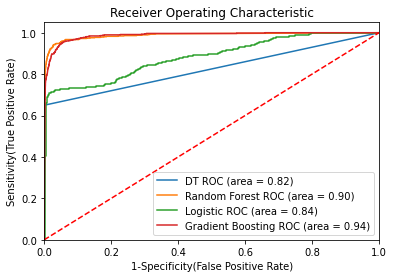

In [56]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'DT',
    'model': dtree,
},
    {
    'label': 'Random Forest',
    'model': rfc,
},
    {
    'label': 'Logistic',
    'model': lg,
},
    
  {
      'label':'Gradient Boosting',
      'model': gb
    
  }
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

# Hyperparameter_Tuning

In [23]:
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}



rs_rfc = RandomizedSearchCV(rfc,
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True,n_jobs=-1)


rs_rfc.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [24]:
rs_rfc.best_params_

{'n_estimators': 20,
 'min_samples_split': 16,
 'min_samples_leaf': 3,
 'max_depth': None}

In [25]:
rs_rfc.score(X_test, y_test)

0.9972504138774922

In [26]:
rfc = RandomForestClassifier(n_estimators=20,
 min_samples_split =14,
 min_samples_leaf= 11,
 max_depth= None)
rfc.fit(X_train,y_train)
rfc_pred_best = rfc.predict(X_test)

print(confusion_matrix(y_test,rfc_pred_best))
print('\n')
print(classification_report(y_test,rfc_pred_best))

[[137929    425]
 [   122    454]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    138354
           1       0.52      0.79      0.62       576

    accuracy                           1.00    138930
   macro avg       0.76      0.89      0.81    138930
weighted avg       1.00      1.00      1.00    138930



In [51]:
feature_importance= {}

for name,score in zip(x,rfc.feature_importances_):
     feature_importance[name]= score
##for key,value in feature_importance.items():
    ##print (key,value)
    
importances = rfc.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
for index in sorted_indices:
    print(X_train.columns[index],'=',feature_importance[X_train.columns[index]])

amt_scaled = 0.5832826831835193
city_pop_scaled = 0.038375076705674714
age_scaled = 0.032732794327744306
lat_scaled = 0.02789573252941985
long_scaled = 0.025734258268327113
shopping_net = 0.02373194448257542
merch_lat_scaled = 0.02170465120880685
merch_long_scaled = 0.020861773982374952
gas_transport = 0.017173037211927526
home = 0.01706438859579632
shopping_pos = 0.016712401634167578
grocery_pos = 0.016599204000209342
kids_pets = 0.016426025791488004
entertainment = 0.01523389699086261
food_dining = 0.014586153438363149
M = 0.014407740904463647
health_fitness = 0.012797639047425846
misc_pos = 0.012787326765220923
misc_net = 0.010582680379586136
personal_care = 0.009900544703719783
Monday = 0.009536976607135832
travel = 0.008767828016081515
Tuesday = 0.008648236171926829
grocery_net = 0.006018783783781186
Sunday = 0.005592029653367932
Wednesday = 0.0039910387339874695
Saturday = 0.0033549343872179716
Friday = 0.002933350078313863
Thursday = 0.002566868416514173
